# Modelling Power Load of Solar Energy
## David Schulte
## Course work: Statistical Tools in Finance and Insurance
## Prof. Dr. López Cabrera

## Imports and helper functions

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.api import OLS, add_constant
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity
import seaborn as sns


## Loading the data

**First we load the data from all four network operators from 2010 until 2020.  
The data can be accessed on https://energy-charts.info/.**

In [2]:
header_list = ['Date', '50Hertz', 'Amprion', 'Tennet', 'Transnet BW']
for year in range(2010, 2021):
    filename = f"energy-charts_Electricity_production_in_Germany_in_{year}.csv"
    filepath = os.path.join('data', filename)
    df_current = pd.read_csv(filepath, sep=',', names=header_list, skiprows=1)
    df_current.fillna(0, inplace=True)

#     df_current["all"] = df_current["50Hertz"] + df_current["Amprion"] + df_current["Tennet"] + df_current["Transnet BW"]
        
    if year == 2010:
        df = df_current
    else:
        df = pd.concat([df, df_current])


In [3]:
df.head()

,Date,50Hertz,Amprion,Tennet,Transnet BW
0,2009-12-31T23:00:00.000Z,0.0,0.0,0.0,0.0
1,2010-01-01T00:00:00.000Z,0.0,0.0,0.0,0.0
2,2010-01-01T01:00:00.000Z,0.0,0.0,0.0,0.0
3,2010-01-01T02:00:00.000Z,0.0,0.0,0.0,0.0
4,2010-01-01T03:00:00.000Z,0.0,0.0,0.0,0.0


**We sum up the energy generation by the network operators to get the total energy generation. Since the data contains values for different time intervals, we aggregate them to get daily power generation.**

In [4]:
df["all"] = df["50Hertz"] + df["Amprion"] + df["Tennet"] + df["Transnet BW"]
df['Date'] = pd.to_datetime(df['Date'])
daily_df = df.groupby([df['Date'].dt.date]).mean()[1:]
daily_df.head()

,50Hertz,Amprion,Tennet,Transnet BW,all
Date,,,,,
2010-01-01,0.004458,0.0,0.048333,0.023208,0.076000
2010-01-02,0.004333,0.0,0.043250,0.020833,0.068417
2010-01-03,0.002167,0.0,0.031625,0.015167,0.048958
2010-01-04,0.001417,0.0,0.088750,0.042667,0.132833
2010-01-05,0.002250,0.0,0.042250,0.020333,0.064833


**This is how our data looks like.**

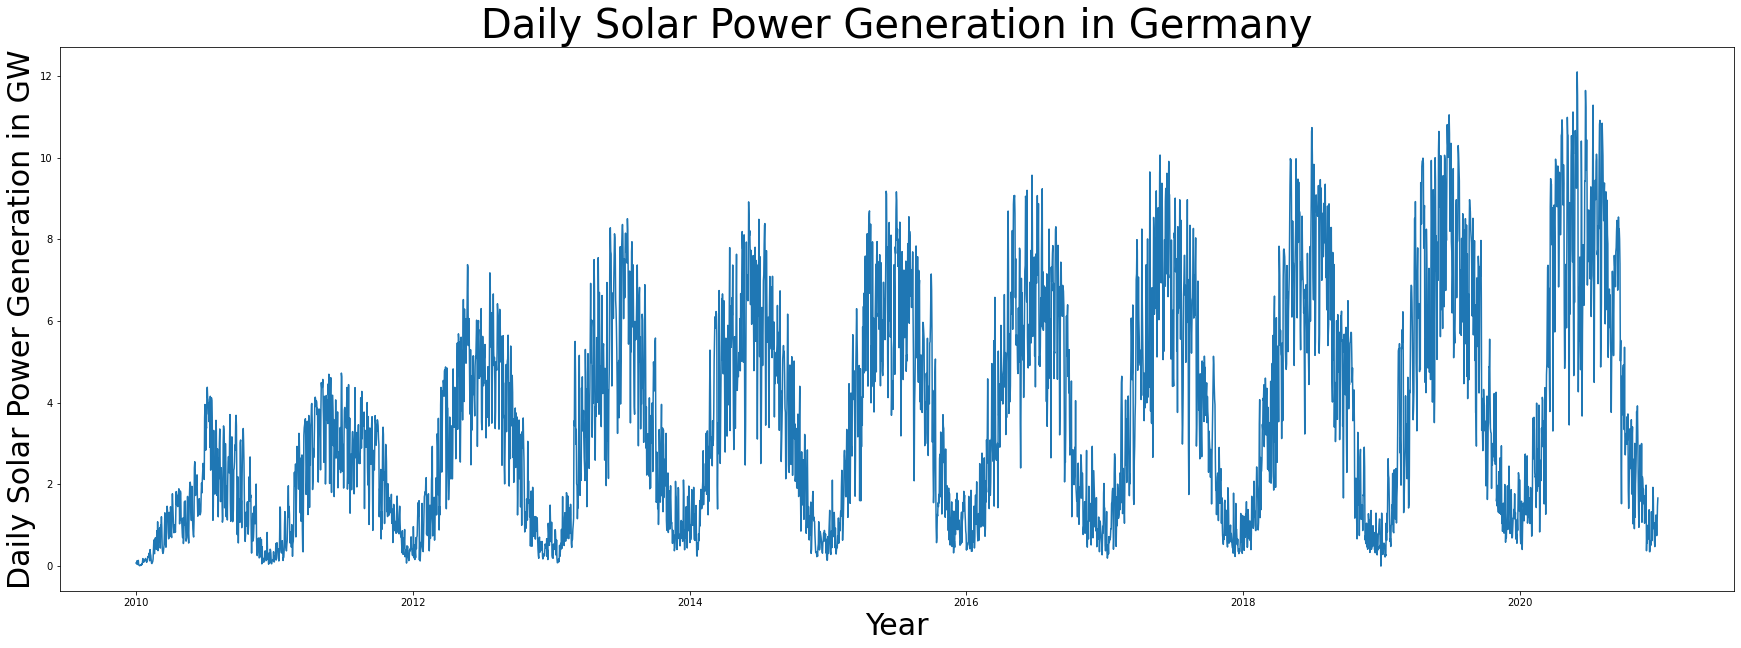

In [5]:
plt.figure(figsize=(30,10))
plt.plot(daily_df['all'])
plt.xlabel('Year', fontsize=30)
plt.ylabel('Daily Solar Power Generation in GW', fontsize=30)
plt.title('Daily Solar Power Generation in Germany', fontsize=40)
plt.savefig('data.png')

## Distribution of the data

**Let us take a look at the distribution of daily power generation.**

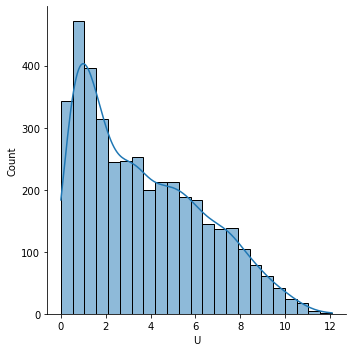

In [6]:
sns.displot(daily_df['all'], kde=True)
plt.xlabel('U')
plt.savefig('datadistr.png')

**We can see that the distribution is skewed to the left. Since we will later apply a linear regression, we would prefer data that is approximately normally distributed. To shift our distribution, we apply the following transformation.**

**First, we apply Min-Max scaling.**

$\tilde{U_t}=\frac{U_t-U_{min}}{U_{max}-U_{min}}$

In [7]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(daily_df['all'].to_numpy().reshape(-1, 1))
epsilon = 0.1
scaled[scaled==0]=epsilon
scaled[scaled==1]=1-epsilon

**Then, we apply a logit normal transformation to the scaled values.**

$U^*=\log{\left(\frac{\tilde{U}_t}{1-\tilde{U}_t}\right)}$

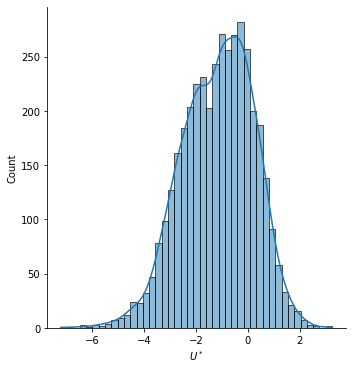

In [8]:
transformed = np.log(scaled/(1-scaled))
daily_df['transformed'] = transformed
sns.displot(transformed, kde=True, legend=None)
plt.xlabel('$U^*$')
plt.savefig('transformeddistr.png')

**Let us take a look at our transformed time series.**

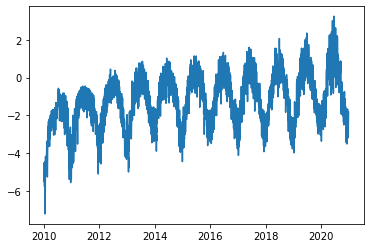

In [9]:
plt.plot(daily_df['transformed'])

## Seasonality

**We can see a strong seasonal component in the data. To get rid of it, we apply a linear regression and continue working with its residuals.  
After thinking about the underlying process behind the data and experimenting with it, we model our data as following:** 


$U^*_t = \beta_0 + \beta_1 \cdot t + \beta_2 \cdot \sqrt[4]t \cos \left(2\pi \frac{t-11}{365}\right)+X_t$  

- $\beta_0$ **is the intercept.**  
- $\beta_1$ **is a linear time coefficient. The behind it is that the amount of solar panels increases steadily over time.**  
- $\beta_2$ **models seasonality. The cosine term describes the yearly seasonality, as power generation heavily depends on natural seasons. The wave is shifted by 11 days. That is because winter solstice is exactly 11 days before New Year. Furthermore, we scale seasonal component by the fourth square-root of time, as a non-linear development of solar energy plants comes into play.**

**We will use the scikit-learn library for implementation. To get more more information about the regression, we will also conduct it using the statsmodels library and print the model summary.**

In [10]:
def get_seasonal_component(timeseries):
    time = np.arange(len(timeseries))
    x_vals = np.array((time, (time**0.25*np.cos(2*np.pi*(time+11)/365)))).T
    lm = LinearRegression().fit(x_vals, timeseries)
    print(f'Intercept: {lm.intercept_}')
    print(f'Coefficients: {lm.coef_}')
    print(f'R-squared: {lm.score(x_vals, timeseries)}')
    return lm.predict(x_vals)


In [11]:
time = np.arange(len(transformed))
x_vals = np.array((time, (time**0.25*np.cos(2*np.pi*(time+11)/365)))).T

model = sm.OLS(transformed, sm.add_constant(x_vals))

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     5272.
Date:                Fri, 05 Aug 2022   Prob (F-statistic):               0.00
Time:                        16:22:05   Log-Likelihood:                -4394.5
No. Observations:                4018   AIC:                             8795.
Df Residuals:                    4015   BIC:                             8814.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0841      0.023    -91.413      0.000      -2.129      -2.039
x1             0.0005   9.83e-06     46.923      0.000       0.000       0.000
x2            -0.2282      0.002    -92.181      0.000      -0.233      -0.223
==============================================================================
Omnibus:                      507.081   Durbin-Watson:                   0.620
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1086.897
Skew:                          -0.766   Prob(JB):                    9.62e-237
Kurtosis:                       5.036   Cond. No.                     4.64e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
f = open('ols.tex', 'w')
f.write(results.summary(xname=['beta0', 'beta1', 'beta2']).as_latex())
f.close()

In [13]:
daily_df['seasonality'] = get_seasonal_component(transformed)
daily_df['cleaned'] = daily_df['transformed'] - daily_df['seasonality']

Intercept: [-2.08409933]
Coefficients: [[ 0.00046127 -0.22820751]]
R-squared: 0.7242120048393265


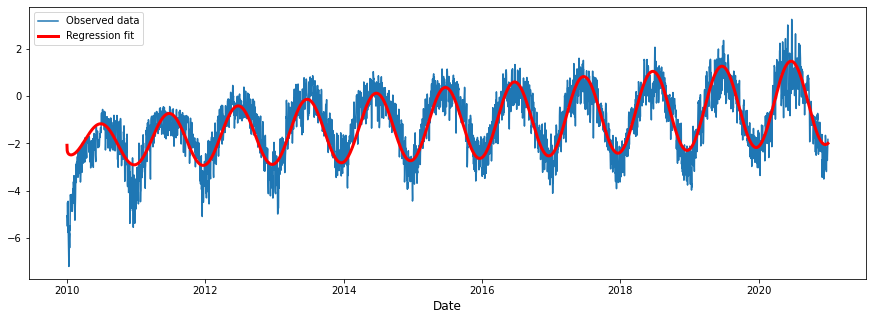

In [14]:
plt.figure(figsize=(15,5))
plt.plot(daily_df['transformed'])
plt.plot(daily_df['seasonality'], c='r', linewidth=3)
plt.legend(['Observed data', 'Regression fit'])
plt.xlabel('Date', fontsize=12)
plt.savefig('seasonality.png')

### Residuals after regression

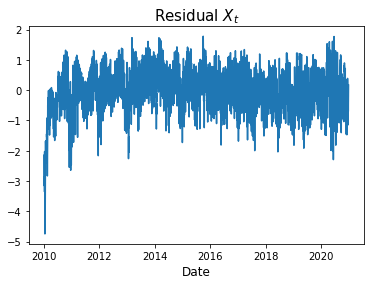

In [15]:
plt.plot(daily_df['cleaned'])
plt.title('Residual $X_t$', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.savefig('afterlm.png')

**The residuals look good, except in the very beginning. That is no problem, since we can just drop the first year of our data and work with the remaining 10 years.**

In [16]:
daily_df = daily_df[365:]
daily_df.head()

,50Hertz,Amprion,Tennet,Transnet BW,all,transformed,seasonality,cleaned
Date,,,,,,,,
2011-01-01,0.011042,0.022042,0.058250,0.009917,0.101250,-4.775061,-2.895385,-1.879675
2011-01-02,0.024542,0.072958,0.090208,0.035667,0.223375,-3.973572,-2.892215,-1.081357
2011-01-03,0.022583,0.080875,0.066042,0.078875,0.248375,-3.865377,-2.888749,-0.976628
2011-01-04,0.019125,0.089500,0.067167,0.067958,0.243750,-3.884564,-2.884988,-0.999576
2011-01-05,0.051042,0.191000,0.205750,0.106500,0.554292,-3.036477,-2.880932,-0.155545


**We will print the RMSE of our residuals.**

In [17]:
rmse = np.linalg.norm(daily_df['cleaned'])/np.sqrt(len(daily2))
print(f'RMSE of residuals: {rmse.round(4)}')

NameError: name 'daily2' is not defined

In [ ]:
sns.displot(daily_df['cleaned'], kde=True)

**We can see that our residuals are approximately normally distributed.**

## Time series modelling

**Now it is time to work on the time series. First, we inspect its partial autocorrelation.**

In [ ]:
fig = plot_pacf(daily_df['cleaned'])
plt.xlabel('Lags', fontsize=12)
plt.title('Partial Autocorrelation', fontsize=15)
plt.savefig('pacf.png')

**Based on this result, we apply a ARIMA(1,0,1) model.**

In [ ]:
model = ARIMA(daily_df['cleaned'], order=(1,0,1)).fit()

**Again, we give out the residuals after applying the ARIMA model.**

In [ ]:
rmse = np.linalg.norm(model.resid)/np.sqrt(len(model.resid))
print(f'RMSE of residuals after ARIMA: {rmse.round(4)}')

In [ ]:
model.summary()

In [ ]:
f = open('arma.tex', 'w')
f.write(model.summary().as_latex())
f.close()

In [ ]:
plt.figure(figsize=(30,10))

# plt.plot(predictions, c='g')
plt.plot(daily_df['cleaned'], c='b')
plt.plot(model.fittedvalues, c='r')
plt.title('Model fit over the whole timespan', fontsize=25)
plt.xlabel('Date', fontsize=18)
plt.legend(['Observed data', 'Model fit'], fontsize=15)
plt.savefig('armafitall.png')

In [ ]:
plt.figure(figsize=(30,10))

daily2['arma_fit'] = model.fittedvalues
# plt.plot(predictions, c='g')
plt.plot(daily_df['cleaned'].iloc[365:365*2], c='b')
plt.plot(daily_df['arma_fit'].iloc[365:365*2], c='r')
plt.title('Model fit in 2012', fontsize=25)
plt.xlabel('Date', fontsize=18)
plt.legend(['Observed data', 'Model fit'], fontsize=15)
plt.savefig('armafit1year.png')

**The statsmodels library returns four plots that describe the model fit.**

In [ ]:
fig = plt.figure(figsize=(20,20))
a = model.plot_diagnostics(fig=fig)
plt.savefig('residplot.png')
plt.close()

![title](residplot.png)